<a href="https://colab.research.google.com/github/HamidrezaKmK/2times2048/blob/master/src/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing


The following code reads 200 samples from Dr. Shahab dataset and 200 samples from UFBA dataset randomly and displays one sample from the selected.

In [14]:
### YOU SHOULD HAVE ACCESS TO THE DATABASE TO RUN THE FOLLOWING CODES ###

# Mount on drive for google colab use
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from cv2 import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import random
from PIL import Image

In [ ]:


# Change to a directory containing Dr.Shahab images:
path_to_dr_shahab = '/content/drive/MyDrive/WORK/Dr Shahab/2021_01/' 

shahab_images = os.listdir(path_to_dr_shahab)
# Change to a directory containing the UFBA images
path_to_brazil = '/content/drive/MyDrive/WORK/UFBA/all_images/'

brazil_images = os.listdir(path_to_brazil)

samples_shahab = []
samples_brazil = []
sample_size_shahab = min(len(shahab_images), 200)
sample_size_brazil = min(len(brazil_images), 200)

for x in random.sample(shahab_images, sample_size_shahab):
  t = cv2.imread(os.path.join(path_to_dr_shahab, x), cv2.IMREAD_GRAYSCALE)
  samples_shahab.append(t)

for x in random.sample(brazil_images, sample_size_brazil):
  t = cv2.imread(os.path.join(path_to_brazil, x), cv2.IMREAD_GRAYSCALE)
  samples_brazil.append(t)


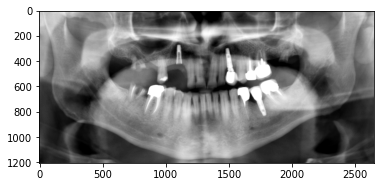

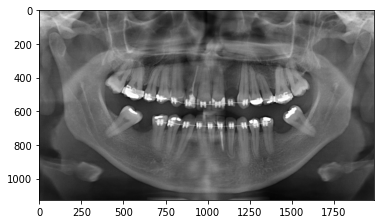

In [ ]:
plt.imshow(samples_shahab[0], cmap='gray')
plt.show()
plt.imshow(samples_brazil[0], cmap='gray')
plt.show()

### Histogram matching and equalization
In the remainder, we can explore different ways of addressing this problem.
A simple way is to perform a mapping between different pixel intensities; which
is known as **histogram equalization**. In this method, assume we are
trying to obtain a mapping from images coming from $\Gamma'$ to
$\Gamma$. We may approximate the Cumulative Density Function (CDF) 
of pixel intensities ranging from 0 to 255 for each of the $\Gamma$
and $\Gamma'$; we can refer to these CDF functions as $F$ and $F'$.
Intensity $x$ from the first dataset is mapped to $F'^{-1} o F(x)$.
Using this simple method we may obtain images similar to $\Gamma$ from
$\Gamma'$.

Run the following piece of code to get the cdf function from both randomly sampled data.

In [ ]:

def get_cdf(list_of_images, exclusion_intensities = []):
  """
  Gets a list of images and returns the cdf of the intensity distribution
  """
  cdf = np.zeros(256)
  for img in tqdm(list_of_images):
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        cdf[img[i,j]] += 1
  cdf = cdf.astype('float64')
  for x in exclusion_intensities:
    cdf[x] = 0
  cdf /= cdf.sum()
  for i in range(1, len(cdf)):
    cdf[i] += cdf[i-1]
  return cdf

In [ ]:
def get_density(cdf):
  d = np.zeros_like(cdf)
  d[0] = cdf[0]
  for i in range(1, len(cdf)):
    d[i] = cdf[i] - cdf[i-1]
  return d

In [ ]:
cdf_brazil = get_cdf(samples_brazil)
cdf_shahab = get_cdf(samples_shahab, exclusion_intensities = [0, 255])
cdf_unif = np.ones(256) * 1 / 256
for i in range(1, 256):
  cdf_unif[i] += cdf_unif[i-1]

100%|██████████| 200/200 [06:24<00:00,  1.92s/it]


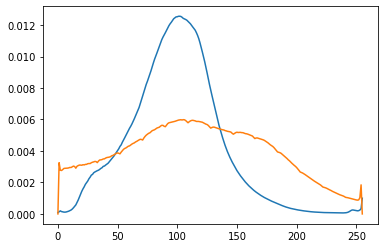

In [ ]:
plt.plot(np.arange(256), get_density(cdf_brazil))
plt.plot(np.arange(256), get_density(cdf_shahab))

Next, we try to obtain a histogram equalization mapping between the two dataset using the method described above.

In [ ]:
def get_mapping(cdf1, cdf2):
  mp = np.zeros(256)
  pnt = 0
  for i in range(256):
    while pnt < 256 and cdf2[pnt] < cdf1[i]:
      pnt += 1
    mp[i] = pnt
    if pnt == 256 or (pnt > 0 and abs(cdf2[pnt - 1] - cdf1[i]) < abs(cdf2[pnt] - cdf1[i])):
      mp[i] = pnt - 1
  return mp


In [ ]:
shahab_to_brazil_matcher = get_mapping(cdf_shahab, cdf_brazil)
shahab_enhancement_equalization = get_mapping(cdf_shahab, cdf_unif)

In [ ]:
np.save('/content/drive/MyDrive/WORK/mappingMatcing.npy', shahab_to_brazil_matcher)
np.save('/content/drive/MyDrive/WORK/mappingEnhancementEqualization.npy', shahab_enhancement_equalization)
#np.load('/content/drive/MyDrive/WORK/mapping.npy', shahab_to_brazil)

Finally, we display an image from Dr. Shahab database and a random image from UFBA dataset; afterward, we map each pixel from the first image to obtain a similar dynamic range to UFBA.

In [12]:
def convert(mapping, img_input):
  img_output = np.zeros_like(img_input)
  for x in range(img_output.shape[0]):
    for y in range(img_output.shape[1]):
      img_output[x, y] = mapping[img_input[x,y]]
  return img_output

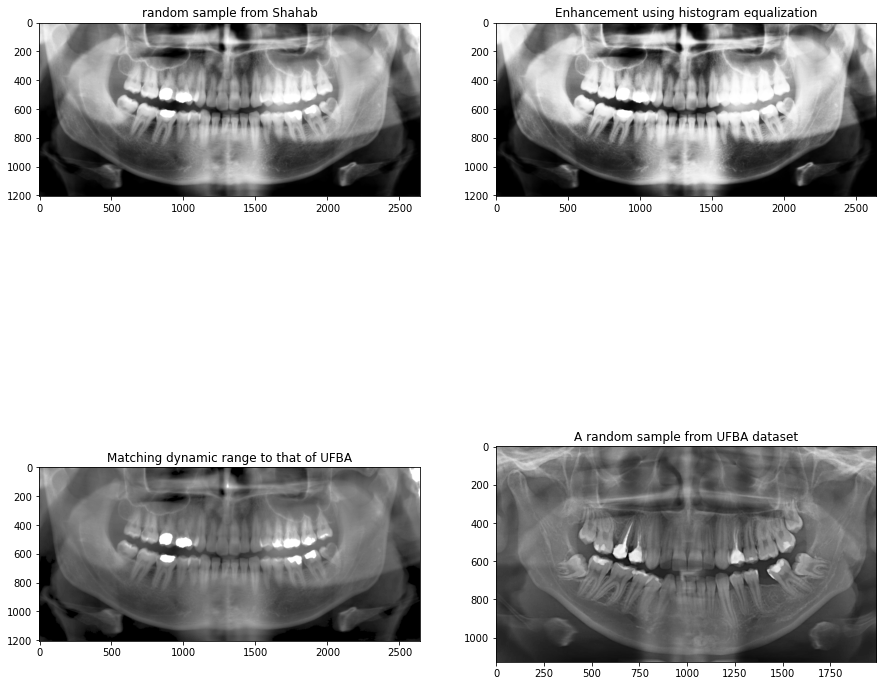

In [ ]:
img = random.choice(samples_shahab)
fig = plt.figure(figsize=(15, 15))
axes = []
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title("random sample from Shahab")
plt.imshow(img, cmap='gray')
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("Enhancement using histogram equalization")
plt.imshow(convert(shahab_enhancement_equalization, img), cmap='gray')
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title("Matching dynamic range to that of UFBA")
plt.imshow(convert(shahab_to_brazil_matcher, img), cmap='gray')
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title("A random sample from UFBA dataset")
plt.imshow(random.choice(samples_brazil), cmap='gray')
plt.show()


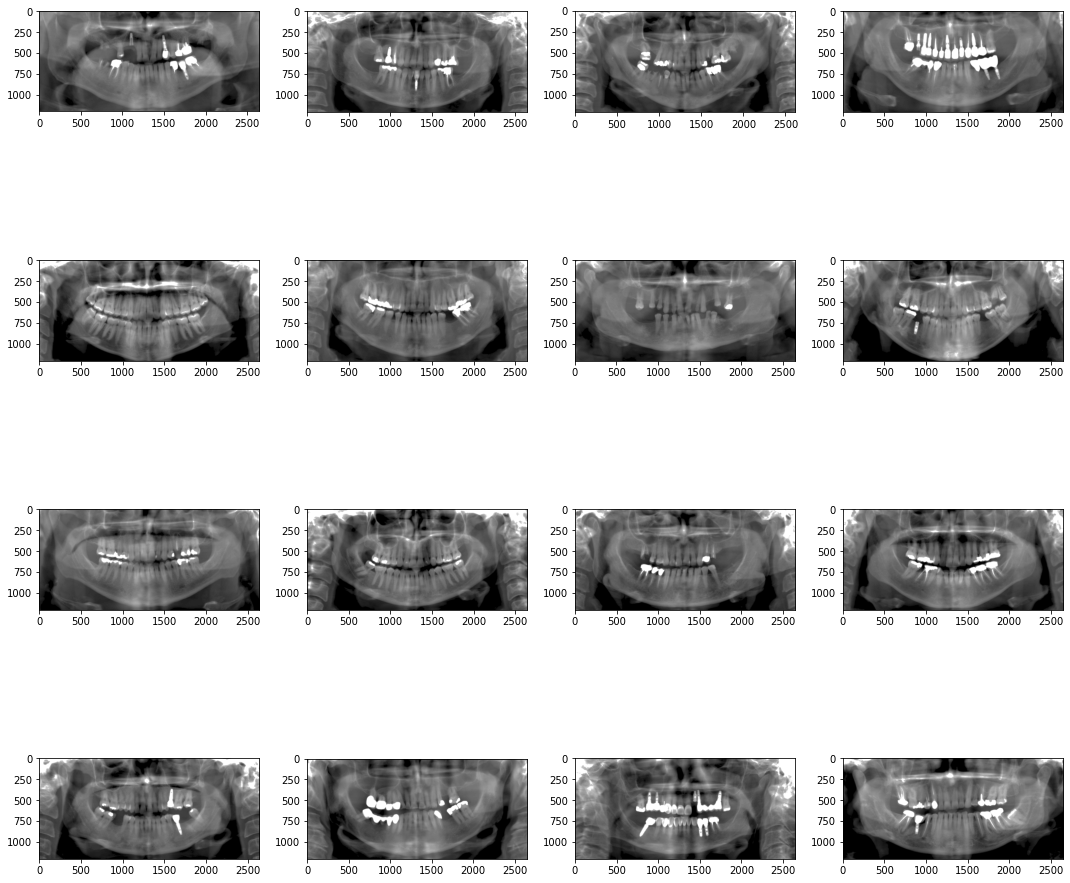

In [ ]:
fig = plt.figure(figsize=(15, 15))
axes = []
for i, img in enumerate(samples_shahab[:16]):
  axes.append(fig.add_subplot(4, 4, i + 1))
  plt.imshow(convert(shahab_to_brazil_matcher, img) , cmap='gray')
fig.tight_layout()
plt.show()

One problem with the mapping based methods is that pixel intensity $x$ is mapped to a particular intensity $y$ regardless of its location in the photo. For example, in the previous 16 samples, you may see parts of the gingival tissue or the spine being colored as bright white that represents restorations on tooth.

On the other hand, there are sharp increases in the pixel intensity of each photo regardless of the surrounding.

## Machine Learning Approaches for Preprocessing

We can facilitate machine learning approaches for correcting the photo as well as unifying the dynamic range of photos. To do so, given a set $S$ of photoes where the semantic segmentation model has been trained on, we augment the data and create pairs of $(P', P)$ which are augmented photos and the correct version of the photo.

To augment the photo, we can use a dynamic range change to the photo using a color curve. Color curves are strong tools to adjust brightness, contrast, gamma, and multiple factors that influence how an image is perceived.

We may create a wide range of transformations using a Bazier curve given two random points. The following image contains a color curve mapping pixel intensities from $0$ to $1$ to the same range using a function.

![Color curve](https://github.com/zlab-foss/dental/tree/master/figs/color-curve.png)

Checkout [this](https://apoorvaj.io/cubic-bezier-through-four-points/) link for more information on how to construct a Bazier curve. Using a set of four points $\{P_1, P_2, T_1, T_2\}, one can construct the following curve:

$$bazier(t) = P_1 (1 - t)^3 + 3 T_1 (1 - t)^2 t + 3 T_2 (1 - t) t^2 + P_2 t^3$$

That being said, if we want to construct a curve that produces a color matching, we can set $P_1 = (0, 0)$ and $P_2 = (1, 1)$ and tune $T_1$ and $T_2$. Furthermore, if we set $T_1 = (a, a')$ and $T_2 = (b, b')$; then,

$$bazier(t) = (3a(1-t)^2t + 3a'(1-t)t^2 + t^3, 3b(1-t)^2t + 3b'(1-t)t^2 + t^3)$$



In [3]:
def bazier(a, a_, b, b_, t):
  return  3 * a * (1 - t) ** 2 * t + a_ * 3 * (1 - t) * t ** 2 + t**3, \
          3 * b * (1 - t) ** 2 * t + b_ * 3 * (1 - t) * t ** 2 + t**3


Run the following code to see the flexibility that Bazier curves have in terms of approximating multiple functions. In a sense, Bazier curves are able to predict any curve changing contrast, brightness, or gamma.

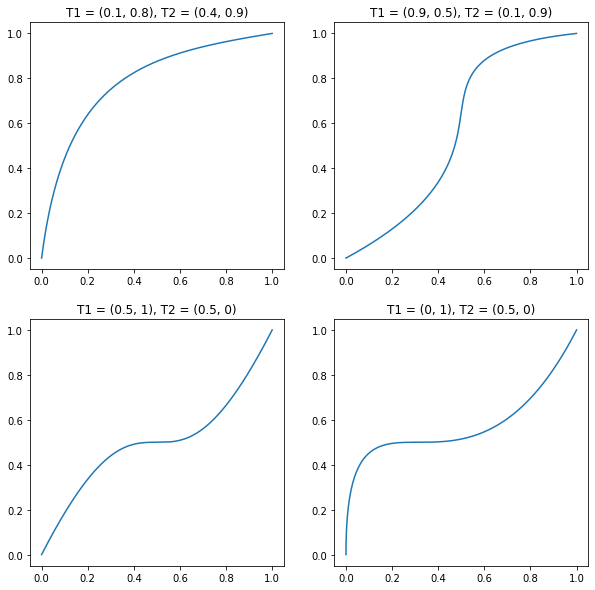

In [10]:

x, y = bazier(0.1, 0.4, 0.8, 0.9, np.linspace(0, 1, 256))
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot(2, 2, 1)
ax1.set_title('T1 = (0.1, 0.8), T2 = (0.4, 0.9)')
plt.plot(x, y)
x, y = bazier(0.9, 0.1, 0.5, 0.9, np.linspace(0, 1, 256))
ax2 = plt.subplot(2, 2, 2)
ax2.set_title('T1 = (0.9, 0.5), T2 = (0.1, 0.9)')
plt.plot(x, y)
x, y = bazier(0.5, 0.5, 1, 0, np.linspace(0, 1, 256))
ax3 = plt.subplot(2, 2, 3)
ax3.set_title('T1 = (0.5, 1), T2 = (0.5, 0)')
plt.plot(x, y)
x, y = bazier(0, 0.5, 1, 0, np.linspace(0, 1, 256))
ax4 = plt.subplot(2, 2, 4)
ax4.set_title('T1 = (0, 1), T2 = (0.5, 0)')
plt.plot(x, y)

plt.show()



Furthermore, by randomly defining $T_1$ and $T_2$ and augmenting the photo using the corresponding Bazier curve, one can obtain such a dataset.
The following code augments the photo given the four parameters of a Bazier curve.

In [30]:
def get_mapping(T1, T2):
  a, b = T1
  a_, b_ = T2
  curve_x, curve_y = bazier(a, a_, b, b_, np.linspace(0, 1, 1000))
  pnt = 0
  mp = np.zeros(256)
  for i, x in enumerate(np.linspace(0, 1, 256)):
    while pnt < len(curve_x) and x >= curve_x[pnt]:
      pnt += 1

    if pnt - 1 >= 0 and (pnt >= len(curve_x) or abs(curve_x[pnt] - x) > abs(curve_x[pnt - 1] - x)):
      t = pnt - 1
    else:
      t = pnt
    mp[i] = int(curve_y[t] * 255)
  return mp

def augment_image(img, T1, T2): 
  mp = get_mapping(T1, T2)
  return convert(mp, img)

Changing a sample image using the Bazier curve:

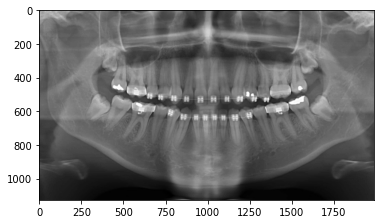

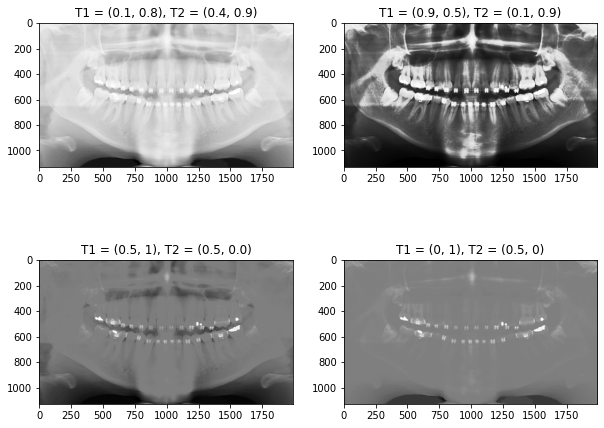

In [35]:
img = cv2.imread('/content/drive/MyDrive/WORK/UFBA/all_images/cate1-00001.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()

fig = plt.figure(figsize=(10, 8))

augmented_img = augment_image(img, (0.1, 0.8), (0.4, 0.9))
ax2 = plt.subplot(2, 2, 1)
ax2.set_title("T1 = (0.1, 0.8), T2 = (0.4, 0.9)")
plt.imshow(augmented_img, cmap='gray')

augmented_img = augment_image(img, (0.9, 0.5), (0.1, 0.9))
ax2 = plt.subplot(2, 2, 2)
ax2.set_title("T1 = (0.9, 0.5), T2 = (0.1, 0.9)")
plt.imshow(augmented_img, cmap='gray')

augmented_img = augment_image(img, (0.5, 1), (0.5, 0))
ax2 = plt.subplot(2, 2, 3)
ax2.set_title("T1 = (0.5, 1), T2 = (0.5, 0.0)")
plt.imshow(augmented_img, cmap='gray')

augmented_img = augment_image(img, (0, 1), (0.5, 0))
ax2 = plt.subplot(2, 2, 4)
ax2.set_title("T1 = (0, 1), T2 = (0.5, 0)")
plt.imshow(augmented_img, cmap='gray')

plt.show()

### Creating a Learning dataset

In this section we will use the UFBA dataset and these random augmentations to create a dataset of augmented and normal pairs.